In [1]:
import pm4py
from pm4py.objects.petri_net.utils import reachability_graph
from pm4py.visualization.transition_system import visualizer as ts_visualizer
from pm4py.objects.petri_net.transport_invariant import semantics as tapn_semantics

In [2]:
tapn, m, fm = pm4py.read_tapn('../models/all/rel_excludesTo_responseTo_A100_B100.tapn')

In [15]:
t = tapn.get_transition_by_id("event_A0")

In [16]:
m2 = tapn_semantics.execute(t,tapn,m)

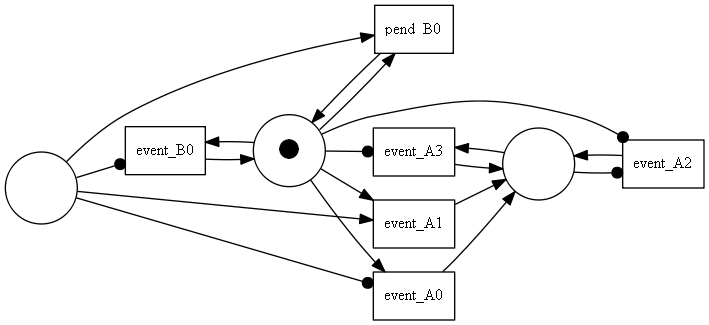

In [5]:
pm4py.view_petri_net(tapn,m,fm,format="png",bgcolor="white")

[i] exec: 120 semantics: <pm4py.objects.petri_net.transport_invariant.semantics.TransportInvariantSemantics object at 0x000001DB7D1A2E60>
<class 'pm4py.objects.petri_net.obj.Marking'>


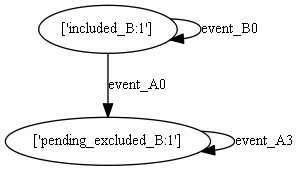

In [9]:
trans_sys = reachability_graph.construct_reachability_graph(tapn, m, use_trans_name=True,
                                                            parameters={'petri_semantics': tapn_semantics.TransportInvariantSemantics() ,'max_elab_time': 2*60})
gviz = ts_visualizer.apply(trans_sys, parameters={ts_visualizer.Variants.VIEW_BASED.value.Parameters.FORMAT: "png","bgcolor":"white"})
ts_visualizer.view(gviz)

# Sketch of optimization
Given a rule or exception + marking do:
    - Take the reachability graph for that rule/exception in isolation.
    - Find the reachable transitions and changing places.
    - Keep only those
Given A -> B -> C and we are mapping B -> C. Check all posibilities of A for a B and use those as starting points for the reachability.
